[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Buddha-subedi/Microwave_Precipitation_Retrievals_from_TLP-R2S/blob/main/TLP-R2S_demo.ipynb)

# <center> <font color='blue'> **An Incremental Learning Framework Linking Reanalysis and Radar Data for Passive Microwave Precipitation Retrievals** <center>

#### <center> <font color='balck'> Buddha Subedi, Mahyar Garshasbi, Ardeshir Ebtehaj <center>
#### <center> Saint Anthony Falls Laboratory, Department of Civil Environmental and Geo- Engineering,
#### <center> University of Minnesota <center>
#### <center> Date: May, 2025 (rev 01)

---
<p align="justify"> This notebook representes the results of an algorithm, called the Boosted Transfer Learning of global Precipitation from Reanalysis data to Satellite observations (TLP-R2S), a novel machine learning framework based on an ensemble of extreme gradient-boosted decision trees that accommodates heterogeneous training data, with emphasis on using Cloud Profiling Radar (CPR) data for training. The algorithm is incrementally trained by combining pre-training on reanalysis precipitation with post-training on coincident Dual-frequency Precipitation Radar (DPR) rainfall and CPR snowfall observations to cope with satellite data sparsity. Applied to PMW retrievals from the Global Precipitation Measurement (GPM) Microwave Imager (GMI) and the Special Sensor Microwave Imager/Sounder (SSMIS), the proposed approach transfers prior information from reanalysis to posterior constraints from radar observations and employs a sequential detection–estimation strategy for precipitation phase and rate. The method substantially improves high-latitude snowfall retrievals, mitigating systematic biases in current GPM products, including Arctic overestimation and Antarctic underestimation. Validation against independent Multi-Radar Multi-Sensor (MRMS) data demonstrates enhanced precipitation phase detection and rate estimation relative to reanalysis-based retrievals and individual spaceborne radar observations, provided sufficient coincident radar data are available for training.

This notebook is organized as follows. Section 1, describes the data including the GPM and CloudSat products as well as the ERA5 reanalysis data from the European Centre for Medium-Range Weather Forecasts (ECMWF). Section 2 describes the methodolgy for training the networks, and the last section provides an example for precipitation orbital retrieval using the proposed algorithm.

# **1. Data**

**1.1** **Data Description**

<span style="color:green;"><b><i>1.1.1 Satellite and Reanalysis Input Data</i></b></span>

Brightness temperatures (TBs) from the SSMIS and GMI radiometers are used in this study as inputs to TLP-R2S, with separate models trained for each sensor. Furthermore, a set of hourly [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) reanalysis products -- available at spatial resolution of 31km is used as ancillary input features to implicitly learn the relationships between land-atmosphere dynamical and thermodynamic state variables and their emissivity.


***SSMIS TBs***
*   Eleven frequency channels from 19 to 183 GHz, available in the GPM V07 data suite


***GMI TBs***
*   Thirteen frequency channels from 10 to 183 GHz

***Atmospheric Variables***
*   tclw = Total Column Cloud Liquid Water ($\rm kg/m^2$)
*   tciw = Total Column Cloud Ice Water ($\rm kg/m^2$)
*   tcwv = Total Column Water Vapor ($\rm kg/m^2$)
*   cape = Convective Available Potential Energy ($\rm j/kg$)
*   t2m = 2m air temperature ($\rm K$)
*   u10 = 10m u-component of wind ($\rm m/s$)
*   v10 = 10m v-component of wind ($\rm m/s$)
*   tcslw = Total Column Supercooled Liquid Water ($\rm \frac{kg}{m^2}$)
*   tcw = Total Column Water ($\rm \frac{kg}{m^3}$)


***Surface Type Variables***
*   lsm = LandSeaMask
*   siconc = Sea Ice Area Fraction
*   sd = Snow Depth ($\rm m$)
*   swvl1 = Volumetric Soil Water Layer1 (-)

<span style="color:green;"><b><i>1.1.2 Output Labels and Rates</i></b></span>

The ERA5 precipitation is used as a pre-training output feature. After pre-training, the model is post-trained on radar observations, with DPR providing the output rainfall labels and rates, while snowfall labels and rates are obtained from the CPR.

More specifically, the near-surface rainfall data are from the 2A-DPR product, based on blind zone extrapolations. The CPR near-surface snowfall is from 2C-PRECIP-COLUMN and the 2C-SNOW-PROFILE, which provide precipitation phase and snowfall rate, respectively.

Figure 1, represents the way the coincidences between GMI and CloudSat profiling radar (CPR) and GMI and DPR are collected. For more details with respect to the CloudSat and GMI please refer to ([2](https://journals.ametsoc.org/view/journals/hydr/22/7/JHM-D-20-0296.1.xml))

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_TLP-R2S/blob/main/images/coincidence_image.png?raw=1" alt="Coincidence Image" width="800"/><br/>
  <em><strong>Figure 1.</strong> Schematic of a CloudSat-GPM coincidence segment (left), and DPR-GMI coincidence (right).</em>
</div>

To minimize redundancy and ambiguity arising from resolution mismatches between datasets, all retrievals are conducted at the native footprints of the SSMIS-S4 (GMI-S2) channels, with approximately 12.5$\times$12.9 (5.1$\times$13.2) km resolution. After harmonization, the analyzed ERA5-labeled SSMIS (GMI) data include approximately 10.4E+6 (7E+6) data points, of which 2.5E+6 (2.5E+6) are labeled as raining and 1.9E+6 (1E+6) as snowing. The CPR and DPR coincidence samples with SSMIS (GMI) after harmonization consist of 4.3E+6 (2.4E+5) and 40.6E+6 (2.9E+9) data points, respectively. The class imbalance ratio is adjusted to maintain the proportions of 3.2--1.3--1 (3.5--2.5--1) for clear--rain--snow, based on a climatological analysis of global ERA5 data.

> **Note:** The demo code implementation below is for the **GMI sensor** and is demonstrated on **partial datasets only**. The example is intended solely to illustrate the methodology and does not represent results from the complete database.


## **1.2 Database Organization and Loading**

**Inputs for the phase detection and rate estimation are as follows:**
> **Inputs:**

*   $\text{TBs} = X_{train}(:,1:13)$ (Brightness Temperature at 13 GMI channels [K])
*   $ \text{tciw} = X_{train}(:,14)$ (Cloud Liquid Water Path)
*   $\text{tclw} = X_{train}(:,15)$ (Cloud Ice Water Path)
*   $\text{tcwv} = X_{train}(:,16)$ (2-meter Air Temperature)
*   $\text{t2m} = X_{train}(:,17)$ (Water Vapor Path)
*   $\text{cape} = X_{train}(:,18)$ (Convective Potential Energy)

*   $\text{u10} = X_{train}(:,19)$ (10m u-component of wind)
*   $ \text{v10} = X_{train}(:,20)$ (10m v-component of wind)
*   $\text{skt} = X_{train}(:,21)$ (Skin Temperature)


*   $\text{sd} = X_{train}(:,22)$ (Snow Depth)
*   $ \text{tcslw} = X_{train}(:,23)$ (Total Column Supercooled Liquid Water)
*   $\text{tcw} = X_{train}(:,24)$ (Total Column Water)
*   $\text{swvl1} = X_{train}(:,25)$ (Volumetric Soil Water Layer1)
*   $\text{lsm} = X_{train}(:,26)$ (LandSeaMask)
*   $\text{siconc} = X_{train}(:,27)$ (Sea Ice Area Fraction)




> **Outputs:**

*   Output of the phase network is a vector containing either of the three integer values **0 (no precipitation)**, **1 (rainfall)**, and **2 (snowfall)**

**For the precipitation estimation, the inputs and outputs are as follows:**

> **Inputs:**

*    The same set of input features that was used for classification is used here as well

> **Outputs**:

*   Output of the estimation network is a vector containing rainfall/snowfall rate [$\rm mm.hr^{-1}$].

## **1.3 Code**
To run this notebook on Google Colab, you need to clone this repository

In [6]:
# Clone the repo
import os
!git clone https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_TLP-R2S.git
os.chdir("Microwave_Precipitation_Retrievals_from_TLP-R2S")

Cloning into 'Microwave_Precipitation_Retrievals_from_TLP-R2S'...
remote: Enumerating objects: 455, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 455 (delta 94), reused 63 (delta 63), pack-reused 338 (from 1)
Receiving objects: 100% (455/455), 107.49 MiB | 28.78 MiB/s, done.
Resolving deltas: 100% (210/210), done.


In [ ]:
!pip install xgboost==1.7.6

In [ ]:
# Import Necessary Packages
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from pathlib import Path
import xgboost as xgb
import os
import scipy.io
import pmw_utils
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error
import scipy.stats as stats
from scipy.interpolate import interp1d
importlib.reload(pmw_utils)
from pmw_utils import plot_confusion_matrix, TLPR2S_model

In [8]:
paths_phase = {
    'cpr_train': 'data/df_cpr_phase_train.npz',
    'cpr_test':  'data/df_cpr_phase_test.npz',
    'dpr_train': 'data/df_dpr_phase_train.npz',
    'dpr_test':  'data/df_dpr_phase_test.npz',
    'era5_train': 'data/df_era5_phase_train.npz',
    'era5_test':  'data/df_era5_phase_test.npz'
}
data = {k: np.load(p) for k, p in paths_phase.items()}
dfs = {k: pd.DataFrame(dict(v)) for k, v in data.items()}
df_cpr_phase_train = dfs['cpr_train']
df_cpr_phase_test  = dfs['cpr_test']
df_dpr_phase_train = dfs['dpr_train']
df_dpr_phase_test  = dfs['dpr_test']
df_era5_phase_train = dfs['era5_train']
df_era5_phase_test  = dfs['era5_test']

In [ ]:
paths_rate = {
    'cpr_snow_rate_train': 'data/df_csat_snow_rate_train.npz',
    'cpr_snow_rate_test':  'data/df_csat_snow_rate_test.npz',
    'dpr_rain_rate_train': 'data/df_dpr_rain_rate_train.npz',
    'dpr_rain_rate_test':  'data/df_dpr_rain_rate_test.npz',
    'era5_snow_rate_train': 'data/df_era5_snow_rate_train.npz',
    'era5_snow_rate_test':  'data/df_era5_snow_rate_test.npz',
    'era5_rain_rate_train': 'data/df_era5_rain_rate_train.npz',
    'era5_rain_rate_test':  'data/df_era5_rain_rate_test.npz'
}

# Load .npz files
data = {k: np.load(p) for k, p in paths_rate.items()}

# Convert to DataFrames
dfs = {k: pd.DataFrame(dict(v)) for k, v in data.items()}

# Assign to variables
df_cpr_snow_rate_train = dfs['cpr_snow_rate_train']
df_cpr_snow_rate_test  = dfs['cpr_snow_rate_test']
df_dpr_rain_rate_train = dfs['dpr_rain_rate_train']
df_dpr_rain_rate_test  = dfs['dpr_rain_rate_test']
df_era5_snow_rate_train = dfs['era5_snow_rate_train']
df_era5_snow_rate_test  = dfs['era5_snow_rate_test']
df_era5_rain_rate_train = dfs['era5_rain_rate_train']
df_era5_rain_rate_test  = dfs['era5_rain_rate_test']

In [ ]:
paths_cdf = {
    'cdf_rain': 'data/df_cdf_rain.npz',
    'cdf_snow':  'data/df_cdf_snow.npz'
}
data = {k: np.load(p) for k, p in paths_cdf.items()}
dfs = {k: pd.DataFrame(dict(v)) for k, v in data.items()}
df_cdf_rain = dfs['cdf_rain']
df_cdf_snow  = dfs['cdf_snow']

# **2.  Methodology**
The TLP-R2S is a two-step precipitation retrieval algorithm, in which the precipitation flag (i.e., clear-sky, rain, and snow) is first determined, followed by the rate estimation. The algorithm comprises three base learners: one for phase classification and two for rainfall and snowfall rate estimations. Each base learner operates in two stages to enable incremental learning and information transfer from pre-training (Stage I) to post-training (Stage II). In Stage I, the model is trained and optimized on ERA5 precipitation labels or rates, with hyperparameters tuned to achieve optimal performance. In Stage II, the architecture of the pre-trained model (e.g., tree depth, number of boosters, splitting conditions) is frozen, and additional boosters are trained to learn fine-scale radar precipitation until a stopping criterion is met.

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_TLP-R2S/blob/main/images/Fig_01.png?raw=1" alt="B-RAINS Architecture" width="700"/><br/>
  <em>
    <strong>Figure 2.</strong> The TLP-R2S architecture employs incremental training of an ensemble of gradient-boosted decision trees to transfer knowledge from ERA5 simulations to spaceborne radar observations. It is a two-step framework: Step 1 performs classification, and Step 2 applies a regression learner depending upon the detected phase. Each step comprises two stages. In Stage I, a finite number of base trees is sequentially boosted to capture prior relationships between input variables and ERA5 precipitation phase and rate. In Stage II, with a frozen pre-trained model, additional boosting rounds are appended to learn posterior relationships between TBs and active radar observations from DPR and CPR, thereby refining phase and rate estimates.
  </em>
</div>

Figure 3 displays precipitation retrievals for a snowstorm and a rainstorm observed by GMI orbit 027551 over the Southern and Indian Oceans. The first column shows results using only $n_e = 90$ boosting rounds, trained exclusively on ERA5 precipitation flags and rates. When additional $n_s$ boosting trees are incrementally added to capture the information content of satellite data pairs, finer spatial details and higher intensity values emerge. Concurrently, low-intensity precipitation at the storm peripheries, initially shaped by learning from the coarse resolution of ERA5, gradually diminishes, as B-RAINS adapts and partially ``forgets'' the low-resolution ERA5 data in favor of a higher fidelity to satellite information.

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_BKnoT-PR/blob/main/images/Fig_03.png?raw=1" alt="Impact of Transfer Learning" width="800"/><br/>
  <em>
    <strong>Figure 3.</strong> The impact of incremental learning on retrievals of a rain storm (a-e) captured by GMI orbit 027551 on January 3, 2019; and a snow storm (f-j) observed by SSMIS orbit 099097 on January 1, 2023 -- where n_e and n_s are boosting rounds before and after freezing, respectively.
  </em>
</div>

## **2.1  Training TLP-R2S**

### **2.1.1  ERA5-CPR base learner for classification**

Stage 1: Learning ERA5 labels

[0]	train-merror:0.10815	test-merror:0.17493
[1]	train-merror:0.09478	test-merror:0.16736
[2]	train-merror:0.08662	test-merror:0.16379
[3]	train-merror:0.08012	test-merror:0.16279
[4]	train-merror:0.07380	test-merror:0.15964
[5]	train-merror:0.06785	test-merror:0.15771
[6]	train-merror:0.06277	test-merror:0.15693
[7]	train-merror:0.05923	test-merror:0.15679
[8]	train-merror:0.05606	test-merror:0.15614
[9]	train-merror:0.05358	test-merror:0.15493
[10]	train-merror:0.05112	test-merror:0.15443
[11]	train-merror:0.04739	test-merror:0.15343
[12]	train-merror:0.04452	test-merror:0.15286
[13]	train-merror:0.04190	test-merror:0.15164
[14]	train-merror:0.03919	test-merror:0.15243
[15]	train-merror:0.03723	test-merror:0.15279
[16]	train-merror:0.03490	test-merror:0.15350
[17]	train-merror:0.03225	test-merror:0.15350
[18]	train-merror:0.02997	test-merror:0.15443
[19]	train-merror:0.02771	test-merror:0.15357
[20]	train-merror:0.02481	test-merror:0.15371
[21]	train-merror:0.02294	test-merror:0.1537

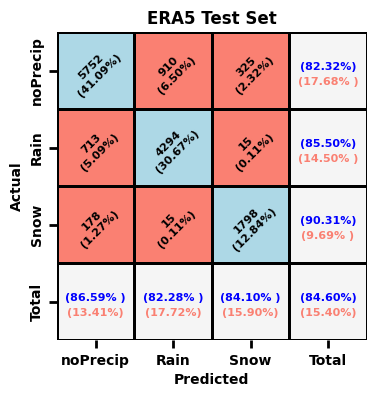

In [7]:
input_vars = ['10v', '10h', '18v', '18h','23v','36v', '36h', '89v', '89h', '166v', '166h','183-3', '183-7',
              'tciw','tclw','tcwv','t2m','cape','u10', 'v10', 'skt',
              'sd', 'tcslw','tcw','swvl1','lsm', 'siconc']

# Train/test split
x_train_era5 = df_era5_phase_train[input_vars]
y_train_era5 = df_era5_phase_train['Prcp flag']

x_test_era5 = df_era5_phase_test[input_vars]
y_test_era5 = df_era5_phase_test['Prcp flag']

classes = np.unique(df_era5_phase_train['Prcp flag'])
class_weights = {0: 1, 1: 1.15, 2: 1.32}

sample_weights_70 = df_era5_phase_train['Prcp flag'].map(lambda x: class_weights[classes.tolist().index(x)])


# Create DMatrix for XGBoost
dtrain_era5 = xgb.DMatrix(x_train_era5, label=y_train_era5, weight=sample_weights_70)
dtest_era5 = xgb.DMatrix(x_test_era5, label=y_test_era5)

# Evaluation set
evals = [(dtrain_era5, 'train'), (dtest_era5, 'test')]

# Model parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'reg_alpha': 1.351,
    'reg_lambda': 5.219,
    'max_depth': 14,
    'num_parallel_tree': 3,
    'learning_rate': 0.41302,
    'gamma': 0.225,
    'verbosity': 0
}

# Train the model
booster_era5 = xgb.train(
    params=params,
    dtrain=dtrain_era5,
    evals=evals,
    num_boost_round=88,
    verbose_eval=True
)

# Predict
y_pred_era5 = booster_era5.predict(dtest_era5)

# Plot confusion matrix
plot_confusion_matrix(y_test_era5, y_pred_era5, 'Predicted', 'Actual', 'ERA5 Test Set')

Stage 2: Finetuning model trained on ERA5 labels with DPR rain and CPR snow labels

In [9]:
def build_phase_dataset(df_cpr, df_dpr, is_cpr=True, random_state=42):

    df_dpr_rain = df_dpr[df_dpr['Prcp flag'] == 1.0]

    df_cpr_clear = df_cpr[df_cpr['Prcp flag'] == 0.0]
    df_cpr_snow = df_cpr[df_cpr['Prcp flag'] == 2.0]

    n_snow = len(df_cpr_snow)

    n_rain = int(2.5 * n_snow)
    n_clear = int(3.5 * n_snow)

    # Sample DPR rain and CPR clear
    df_dpr_rain_sampled = df_dpr_rain.sample(
        n=n_rain,
        replace=(n_rain > len(df_dpr_rain)),
        random_state=random_state
    )

    df_cpr_clear_sampled = df_cpr_clear.sample(
        n=n_clear,
        replace=(n_clear > len(df_cpr_clear)),
        random_state=random_state
    )

    # Keep all snow
    df_cpr_snow_sampled = df_cpr_snow.copy()

    df_phase = pd.concat(
        [df_dpr_rain_sampled, df_cpr_clear_sampled, df_cpr_snow_sampled],
        ignore_index=True
    )

    # Shuffle
    df_phase = df_phase.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return df_phase


df_phase_train = build_phase_dataset(df_cpr_phase_train, df_dpr_phase_train)
df_phase_test = build_phase_dataset(df_cpr_phase_test, df_dpr_phase_test)


print("TRAIN:\n", df_phase_train['Prcp flag'].value_counts())
print("TEST:\n", df_phase_test['Prcp flag'].value_counts())

TRAIN:
 Prcp flag
0.0    9838
1.0    7027
2.0    2811
Name: count, dtype: int64
TEST:
 Prcp flag
0.0    2446
1.0    1747
2.0     699
Name: count, dtype: int64


In second round of training, architecture of trees trained on the ERA5 will be frozen -- that is, their structure, including the number of trees, depth, nodes, and splitting criteria, is fixed. Additional bottom boosters are then appended and trained on satellite-based observations to capture the finer-scale information embedded in active retrievals.

In [14]:
!pip install xgboost==1.7.6


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.2
    Uninstalling xgboost-3.1.2:
      Successfully uninstalled xgboost-3.1.2


In [13]:
x_train_sat = df_phase_train[input_vars]
y_train_sat = df_phase_train['Prcp flag']

x_test_sat = df_phase_test[input_vars]
y_test_sat = df_phase_test['Prcp flag']


x_era5 = df_era5_phase_test[input_vars]
y_era5 = df_era5_phase_test['Prcp flag']

classes = np.unique(df_phase_train['Prcp flag'])
class_weights = {0: 1, 1: 1.267, 2: 1.966}


sample_weights_sat = df_phase_train['Prcp flag'].map(lambda x: class_weights[classes.tolist().index(x)])


dtrain_sat = xgb.DMatrix(x_train_sat, label=y_train_sat, weight=sample_weights_sat)
dtest_sat = xgb.DMatrix(x_test_sat, label=y_test_sat)
dera5 = xgb.DMatrix(x_era5, label=y_era5)

evals = [(dtrain_sat, 'train_cpr'), (dtest_sat, 'test_cpr'), (dera5, 'era5')]

f1_train_dpr_rain_values, f1_test_dpr_rain_values, f1_era5_rain_values = [], [], []
f1_train_cpr_snow_values, f1_test_cpr_snow_values, f1_era5_snow_values = [], [], []

def f1_eval_all_classes(preds, dmatrix):
    labels = dmatrix.get_label()
    arr = np.array(preds)
    if arr.ndim == 2:
        p = arr.argmax(axis=1)
    else:
        p = arr.astype(int)
    f1_scores = f1_score(labels, p, labels=[1, 2], average=None)
    f1_rain, f1_snow = f1_scores[0], f1_scores[1]
    if dmatrix is dtrain_sat:
        f1_train_dpr_rain_values.append(f1_rain)
        f1_train_cpr_snow_values.append(f1_snow)
    elif dmatrix is dtest_sat:
        f1_test_dpr_rain_values.append(f1_rain)
        f1_test_cpr_snow_values.append(f1_snow)
    elif dmatrix is dera5:
        f1_era5_rain_values.append(f1_rain)
        f1_era5_snow_values.append(f1_snow)
    return "f1_snow", f1_snow



params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'subsample': 0.5,
    'reg_alpha': 6.948,
    'reg_lambda': 5.0278,
    'max_depth': 16,
    'num_parallel_tree': 6,
    'learning_rate': 0.011,
    'gamma': 0.32,
    'verbosity': 0
}

booster = xgb.train(params, dtrain_sat, num_boost_round=250, evals=evals, feval=f1_eval_all_classes)


y_pred = booster.predict(dtest_sat)
accuracy = accuracy_score(y_test_sat, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

TypeError: train() got an unexpected keyword argument 'feval'

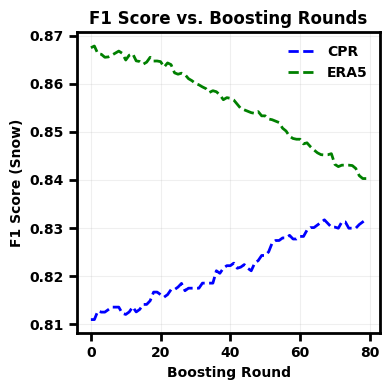

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(f1_test_cpr_snow_values, label='CPR', color='blue', linewidth=2, linestyle='--')
plt.plot(f1_era5_snow_values, label='ERA5', color='green', linewidth=2, linestyle='--')

plt.xlabel('Boosting Round', fontsize=10, fontweight='bold')
plt.ylabel('F1 Score (Snow)', fontsize=10, fontweight='bold')
plt.title('F1 Score vs. Boosting Rounds', fontsize=12, fontweight='bold')

plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight': 'bold'})

plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### **2.1.2  ERA5-DPR base learner for classification**

Fine tune the model trained on ERA5 based on Learning from DPR Phase

In [ ]:
# Prepare DPR data
x_train_dpr = df_dpr_phase_train[input_vars]
y_train_dpr = df_dpr_phase_train['Prcp flag']

x_test_dpr = df_dpr_phase_test[input_vars]
y_test_dpr = df_dpr_phase_test['Prcp flag']

# Class weights
classes = np.unique(y_train_dpr)
class_weights = {0: 1, 1: 1.573, 2: 1}

# Sample weights
sample_weights_dpr = y_train_dpr.map(lambda x: class_weights[classes.tolist().index(x)])

# DMatrix creation
dtrain_dpr = xgb.DMatrix(x_train_dpr, label=y_train_dpr, weight=sample_weights_dpr)
dtest_dpr = xgb.DMatrix(x_test_dpr, label=y_test_dpr)
dtest_era5 = xgb.DMatrix(df_era5_phase_test[input_vars], label=df_era5_phase_test['Prcp flag'])

# Eval sets
evals = [(dtrain_dpr, 'train_dpr'), (dtest_dpr, 'test_dpr'), (dtest_era5, 'era5')]

# Tracking F1 scores
f1_train_dpr_rain_values, f1_test_dpr_rain_values, f1_era5_rain_values = [], [], []
f1_train_dpr_snow_values, f1_test_dpr_snow_values, f1_era5_snow_values = [], [], []

# F1 evaluator function
def f1_eval_all_classes(preds, dtrain):
    labels = dtrain.get_label()
    preds = preds.argmax(axis=1)
    f1_scores = f1_score(labels, preds, labels=[1, 2], average=None)
    f1_rain, f1_snow = f1_scores[0], f1_scores[1]

    if dtrain == dtrain_dpr:
        f1_train_dpr_rain_values.append(f1_rain)
        f1_train_dpr_snow_values.append(f1_snow)
    elif dtrain == dtest_dpr:
        f1_test_dpr_rain_values.append(f1_rain)
        f1_test_dpr_snow_values.append(f1_snow)
    elif dtrain == dtest_era5:
        f1_era5_rain_values.append(f1_rain)
        f1_era5_snow_values.append(f1_snow)

    return 'f1_rain', f1_rain

# Set model parameters
params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'merror',
    'subsample': 0.5,
    'reg_alpha': 6.948,
    'reg_lambda': 5.0278,
    'max_depth': 11,
    'num_parallel_tree': 6,
    'learning_rate': 0.01,
    'gamma': 0.32,
    'verbosity': 0
}

# Fine-tune model with DPR data (warm-start from booster_era5)
booster_dpr = xgb.train(
    params,
    dtrain_dpr,
    num_boost_round=50,
    evals=evals,
    xgb_model=booster_era5,  # warm-start from previously trained model
    verbose_eval=True,
    feval=f1_eval_all_classes
)

# Predict on test set
y_pred_dpr_finetune_proba = booster_dpr.predict(dtest_dpr)
y_pred_dpr_finetune_label = y_pred_dpr_finetune_proba.argmax(axis=1)
# Evaluate final accuracy and F1 score for rain
accuracy = accuracy_score(y_test_dpr, y_pred_dpr_finetune_label)
f1_rain = f1_score(y_test_dpr, y_pred_dpr_finetune_label, labels=[1], average='macro')

print(f"Test accuracy: {accuracy:.2f}")
print(f"F1 score (rain class): {f1_rain:.3f}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train_dpr-merror:0.30770	train_dpr-f1_rain:0.69181	test_dpr-merror:0.34464	test_dpr-f1_rain:0.69942	era5-merror:0.15143	era5-f1_rain:0.84004
[1]	train_dpr-merror:0.30654	train_dpr-f1_rain:0.69272	test_dpr-merror:0.34348	test_dpr-f1_rain:0.70027	era5-merror:0.15129	era5-f1_rain:0.83964
[2]	train_dpr-merror:0.30528	train_dpr-f1_rain:0.69377	test_dpr-merror:0.34196	test_dpr-f1_rain:0.70127	era5-merror:0.15193	era5-f1_rain:0.83895
[3]	train_dpr-merror:0.30416	train_dpr-f1_rain:0.69460	test_dpr-merror:0.34125	test_dpr-f1_rain:0.70175	era5-merror:0.15200	era5-f1_rain:0.83861
[4]	train_dpr-merror:0.30281	train_dpr-f1_rain:0.69572	test_dpr-merror:0.34000	test_dpr-f1_rain:0.70254	era5-merror:0.15200	era5-f1_rain:0.83829
[5]	train_dpr-merror:0.30184	train_dpr-f1_rain:0.69663	test_dpr-merror:0.33884	test_dpr-f1_rain:0.70358	era5-merror:0.15179	era5-f1_rain:0.83843
[6]	train_dpr-merror:0.30060	train_dpr-f1_rain:0.69761	test_dpr-merror:0.33750	test_dpr-f1_rain:0.70451	era5-merror:0.15271	era5-f

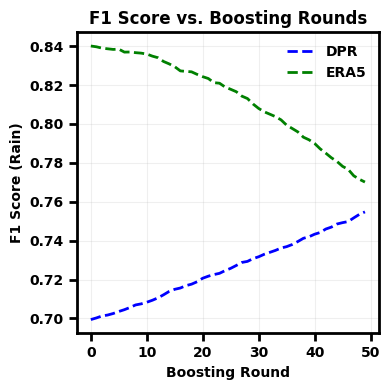

In [ ]:
plt.figure(figsize=(4, 4))

plt.plot(f1_test_dpr_rain_values, label='DPR', color='blue', linewidth=2, linestyle='--')
plt.plot(f1_era5_rain_values, label='ERA5', color='green', linewidth=2, linestyle='--')

plt.xlabel('Boosting Round', fontsize=10, fontweight='bold')
plt.ylabel('F1 Score (Rain)', fontsize=10, fontweight='bold')
plt.title('F1 Score vs. Boosting Rounds', fontsize=12, fontweight='bold')

plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight': 'bold'})
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### **2.1.3  Meta model for label predictions**

Preparing the datasets for the meta model by combining equal number of samples from the satellite and the reanalysis datasets.

In [ ]:
#### Satellite dataset for the meta-model
snow_train_meta_cpr= df_cpr_phase_train[df_cpr_phase_train['Prcp flag']==2]
snow_test_meta_cpr = df_cpr_phase_test[df_cpr_phase_test['Prcp flag']==2]

df_train_sat_meta = shuffle(pd.concat([
    df_cpr_phase_train[df_cpr_phase_train['Prcp flag'] == 2],
    df_dpr_phase_train[df_dpr_phase_train['Prcp flag'] == 1].sample(n=int(2.5 * snow_train_meta_cpr.shape[0]), random_state=42),
    df_cpr_phase_train[df_cpr_phase_train['Prcp flag'] == 0].sample(n=int(1.75 * snow_train_meta_cpr.shape[0]), random_state=42),
    df_dpr_phase_train[df_dpr_phase_train['Prcp flag'] == 0].sample(n=int(1.75 * snow_train_meta_cpr.shape[0]), random_state=42)
], ignore_index=True), random_state=42).reset_index(drop=True)

df_test_sat_meta = shuffle(pd.concat([
    df_cpr_phase_test[df_cpr_phase_test['Prcp flag'] == 2],
    df_dpr_phase_test[df_dpr_phase_test['Prcp flag'] == 1].sample(n=int(2.5 * snow_test_meta_cpr.shape[0]), random_state=42),
    df_cpr_phase_test[df_cpr_phase_test['Prcp flag'] == 0].sample(n=int(1.75 * snow_test_meta_cpr.shape[0]), random_state=42),
    df_dpr_phase_test[df_dpr_phase_test['Prcp flag'] == 0].sample(n=int(1.75 * snow_test_meta_cpr.shape[0]), random_state=42)
], ignore_index=True), random_state=42).reset_index(drop=True)


#### ERA5 dataset for the meta-model
clear_train_meta_era5 = df_era5_phase_train[df_era5_phase_train['Prcp flag']==0].sample(n=int(3.5 * snow_train_meta_cpr.shape[0]), random_state=42)
clear_test_meta_era5= df_era5_phase_test[df_era5_phase_test['Prcp flag']==0].sample(n=int(3.5 * snow_test_meta_cpr.shape[0]), random_state=42)

rain_train_meta_era5= df_era5_phase_train[df_era5_phase_train['Prcp flag']==1].sample(n=int(2.5 * snow_train_meta_cpr.shape[0]), random_state=42)
rain_test_meta_era5= df_era5_phase_test[df_era5_phase_test['Prcp flag']==1].sample(n=int(2.5 * snow_test_meta_cpr.shape[0]), random_state=42)

snow_train_meta_era5 = df_era5_phase_train[df_era5_phase_train['Prcp flag']==2].sample(n=snow_train_meta_cpr.shape[0], random_state=42)
snow_test_meta_era5 = df_era5_phase_test[df_era5_phase_test['Prcp flag']==2].sample(n=snow_test_meta_cpr.shape[0], random_state=42)

df_train_era5_meta = pd.concat([clear_train_meta_era5, rain_train_meta_era5, snow_train_meta_era5], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df_test_era5_meta  = pd.concat([clear_test_meta_era5, rain_test_meta_era5, snow_test_meta_era5], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

#### Merging the ERA5 and satellite labels for meta-model
df_train_meta = pd.concat([df_train_era5_meta, df_train_sat_meta], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df_test_meta  = pd.concat([df_test_era5_meta, df_test_sat_meta], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

Training the Meta-model

In [ ]:
x_train_get_data_for_meta = df_train_meta[input_vars]
x_test_get_data_for_meta = df_test_meta[input_vars]

dtrain = xgb.DMatrix(x_train_get_data_for_meta)
dtest = xgb.DMatrix(x_test_get_data_for_meta)

## Creating features based on DPR phase probabilities
dpr_pred_proba_for_train = booster_dpr.predict(dtrain)
dpr_pred_proba_for_test = booster_dpr.predict(dtest)

df_train_meta['dpr_p0'], df_train_meta['dpr_p1'], df_train_meta['dpr_p2'] = \
    dpr_pred_proba_for_train[:, 0], dpr_pred_proba_for_train[:, 1], dpr_pred_proba_for_train[:, 2]

df_test_meta['dpr_p0'], df_test_meta['dpr_p1'], df_test_meta['dpr_p2'] = \
    dpr_pred_proba_for_test[:, 0], dpr_pred_proba_for_test[:, 1], dpr_pred_proba_for_test[:, 2]

## Creating features based on CPR phase probabilities
cpr_pred_proba_for_train = booster_cpr.predict(dtrain)
cpr_pred_proba_for_test = booster_cpr.predict(dtest)

df_train_meta['cpr_p0'], df_train_meta['cpr_p1'], df_train_meta['cpr_p2'] = \
    cpr_pred_proba_for_train[:, 0], cpr_pred_proba_for_train[:, 1], cpr_pred_proba_for_train[:, 2]

df_test_meta['cpr_p0'], df_test_meta['cpr_p1'], df_test_meta['cpr_p2'] = \
    cpr_pred_proba_for_test[:, 0], cpr_pred_proba_for_test[:, 1], cpr_pred_proba_for_test[:, 2]

[0]	train-mlogloss:0.79255	train-merror:0.13145	test-mlogloss:0.82131	test-merror:0.19041
[1]	train-mlogloss:0.62473	train-merror:0.12973	test-mlogloss:0.67470	test-merror:0.19062
[2]	train-mlogloss:0.52029	train-merror:0.12820	test-mlogloss:0.58679	test-merror:0.19052
[3]	train-mlogloss:0.45073	train-merror:0.12711	test-mlogloss:0.53175	test-merror:0.19062
[4]	train-mlogloss:0.40297	train-merror:0.12594	test-mlogloss:0.49606	test-merror:0.19011
[5]	train-mlogloss:0.36951	train-merror:0.12536	test-mlogloss:0.47294	test-merror:0.18990
[6]	train-mlogloss:0.34511	train-merror:0.12383	test-mlogloss:0.45753	test-merror:0.19041
[7]	train-mlogloss:0.32673	train-merror:0.12256	test-mlogloss:0.44747	test-merror:0.18960
[8]	train-mlogloss:0.31295	train-merror:0.12142	test-mlogloss:0.44052	test-merror:0.18980
[9]	train-mlogloss:0.30221	train-merror:0.12015	test-mlogloss:0.43567	test-merror:0.19052
[10]	train-mlogloss:0.29355	train-merror:0.11961	test-mlogloss:0.43236	test-merror:0.19041
[11]	trai

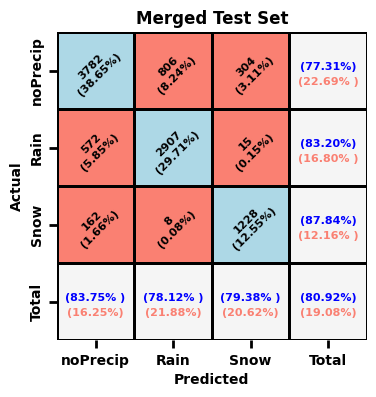

In [ ]:
new_input_vars = ['dpr_p0', 'dpr_p1', 'dpr_p2', 'cpr_p0', 'cpr_p1', 'cpr_p2']

x_train_meta = df_train_meta[new_input_vars]
y_train_meta = df_train_meta['Prcp flag']

x_test_meta = df_test_meta[new_input_vars]
y_test_meta = df_test_meta['Prcp flag']

# Prepare the DMatrix for train and test data
dtrain_meta = xgb.DMatrix(x_train_meta, label=y_train_meta)
dtest_meta = xgb.DMatrix(x_test_meta, label=y_test_meta)

# Define evaluation metrics, watchlist to monitor test metrics
evals = [(dtrain_meta, 'train'), (dtest_meta, 'test')]

params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': ['mlogloss', 'merror'],
    'subsample': 0.5,
    'reg_alpha': 0.095,
    'reg_lambda': 7.843,
    'max_depth': 15,
    'num_parallel_tree': 3,
    'learning_rate': 0.330808,
    'gamma': 0.661776,
    'verbosity': 1
}

# Train the model (meta_model)
meta_model = xgb.train(
    params=params,
    dtrain=dtrain_meta,
    evals=evals,
    num_boost_round=20,
    verbose_eval=True
)

# Predict probabilities
y_pred_proba = meta_model.predict(dtest_meta)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_proba, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_test_meta, y_pred, 'Predicted', 'Actual', 'Merged Test Set')

### **2.1.4  ERA5-CPR base learner for snowfall retrievals**

Training the base learner for the snow rate estimation by first learning the ERA5 and then fine tuning on CloudSat snow rate

In [ ]:
X_train_snow_era5 = df_era5_snow_rate_train[input_vars]
y_train_snow_era5 = df_era5_snow_rate_train['snow_rate']

X_test_snow_era5 = df_era5_snow_rate_test[input_vars]
y_test_snow_era5 = df_era5_snow_rate_test['snow_rate']



# Convert to DMatrix format
dtrain_snow_era5 = xgb.DMatrix(X_train_snow_era5, label=y_train_snow_era5)
dtest_snow_era5 = xgb.DMatrix(X_test_snow_era5, label=y_test_snow_era5)


# Define evaluation metrics and watchlist
evals = [(dtrain_snow_era5, 'train'), (dtest_snow_era5, 'test')]

evals_result = {}

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'seed': 42,
    'learning_rate': 0.0392,
    'max_depth': 14,
    'reg_alpha': 4.52,
    'reg_lambda': 7.139,
    'n_estimators': 52,
    'num_parallel_tree': 6,
    'eval_metric': ['rmse']
}

# Train the model with early stopping
xgb_reg_snow_era5 = xgb.train(params, dtrain_snow_era5, num_boost_round=52, evals=evals, evals_result=evals_result, early_stopping_rounds=5)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:17:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.20422	test-rmse:0.20202
[1]	train-rmse:0.19941	test-rmse:0.19753
[2]	train-rmse:0.19483	test-rmse:0.19331
[3]	train-rmse:0.19048	test-rmse:0.18929
[4]	train-rmse:0.18636	test-rmse:0.18532
[5]	train-rmse:0.18241	test-rmse:0.18157
[6]	train-rmse:0.17859	test-rmse:0.17794
[7]	train-rmse:0.17495	test-rmse:0.17466
[8]	train-rmse:0.17155	test-rmse:0.17149
[9]	train-rmse:0.16825	test-rmse:0.16837
[10]	train-rmse:0.16514	test-rmse:0.16550
[11]	train-rmse:0.16212	test-rmse:0.16258
[12]	train-rmse:0.15923	test-rmse:0.15982
[13]	train-rmse:0.15648	test-rmse:0.15729
[14]	train-rmse:0.15389	test-rmse:0.15482
[15]	train-rmse:0.15137	test-rmse:0.15254
[16]	train-rmse:0.14901	test-rmse:0.15045
[17]	train-rmse:0.14665	test-rmse:0.14838
[18]	train-rmse:0.14446	test-rmse:0.14643
[19]	train-rmse:0.14232	test-rmse:0.14455
[20]	train-rmse:0.14022	test-rmse:0.14287
[21]	train-rmse:0.13824	test-rmse:0.14116
[22]	train-rmse:0.13641	test-rmse:0.13952
[23]	train-rmse:0.13461	test-rmse:0.13810
[2

Fine tuning the model based on CPR snow rate

In [ ]:
X_train_snow_sat = df_cpr_snow_rate_train[input_vars]
y_train_snow_sat = df_cpr_snow_rate_train['snow_rate']
X_test_snow_sat = df_cpr_snow_rate_test[input_vars]
y_test_snow_sat = df_cpr_snow_rate_test['snow_rate']

dtrain_snow_rate_sat = xgb.DMatrix(X_train_snow_sat, label=y_train_snow_sat)
dtest_snow_rate_sat = xgb.DMatrix(X_test_snow_sat, label=y_test_snow_sat)

evals = [(dtest_snow_era5, 'test_era5'), (dtest_snow_rate_sat, 'test_sat'), (dtrain_snow_rate_sat, 'train_sat')]
evals_result = {}

# Set parameters for fine-tuning
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.014,
    'eval_metric': 'rmse',
    'max_depth': 15
}

# Continue training with the new data
snow_rate_booster = xgb.train(
    params,
    dtrain_snow_rate_sat,
    num_boost_round=104,
    evals=evals,
    xgb_model=xgb_reg_snow_era5,
    evals_result=evals_result,
    verbose_eval=True
)


y_pred_snow_rate_sat = snow_rate_booster.predict(dtest_snow_rate_sat)

mse_new = mean_squared_error(y_test_snow_sat, y_pred_snow_rate_sat)
print(f"Test Mean Squared Error: {mse_new:.2f}")

[0]	test_era5-rmse:0.11892	test_sat-rmse:0.38786	train_sat-rmse:0.32433
[1]	test_era5-rmse:0.11875	test_sat-rmse:0.38672	train_sat-rmse:0.32287
[2]	test_era5-rmse:0.11861	test_sat-rmse:0.38560	train_sat-rmse:0.32141
[3]	test_era5-rmse:0.11851	test_sat-rmse:0.38450	train_sat-rmse:0.31995
[4]	test_era5-rmse:0.11842	test_sat-rmse:0.38342	train_sat-rmse:0.31853
[5]	test_era5-rmse:0.11835	test_sat-rmse:0.38238	train_sat-rmse:0.31715
[6]	test_era5-rmse:0.11831	test_sat-rmse:0.38134	train_sat-rmse:0.31578
[7]	test_era5-rmse:0.11830	test_sat-rmse:0.38030	train_sat-rmse:0.31443
[8]	test_era5-rmse:0.11828	test_sat-rmse:0.37933	train_sat-rmse:0.31309
[9]	test_era5-rmse:0.11823	test_sat-rmse:0.37832	train_sat-rmse:0.31175
[10]	test_era5-rmse:0.11824	test_sat-rmse:0.37738	train_sat-rmse:0.31045
[11]	test_era5-rmse:0.11829	test_sat-rmse:0.37641	train_sat-rmse:0.30913
[12]	test_era5-rmse:0.11831	test_sat-rmse:0.37548	train_sat-rmse:0.30785
[13]	test_era5-rmse:0.11837	test_sat-rmse:0.37449	train_sat-r

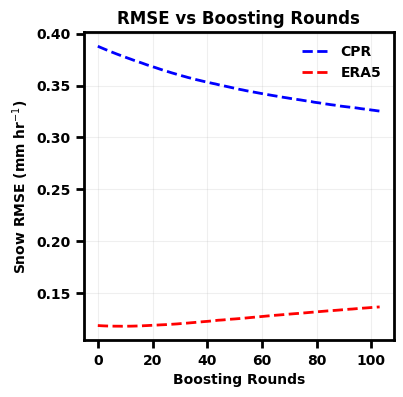

In [ ]:
# Extract RMSE values
train_rmse = evals_result['test_sat']['rmse']
test_rmse = evals_result['test_era5']['rmse']

# Plot RMSE vs Boosting rounds
plt.figure(figsize=(4, 4))
plt.plot(train_rmse, label='CPR', color='blue', linestyle='--', linewidth=2)
plt.plot(test_rmse, label='ERA5', color='red', linestyle='--', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=10, fontweight='bold')
plt.ylabel('Snow RMSE (mm hr$^{-1}$)', fontsize=10, fontweight='bold')


plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)
plt.title('RMSE vs Boosting Rounds', fontsize=12, fontweight='bold')
plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight':'bold'})
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
plt.grid(True, alpha=0.2)
plt.show()

### **2.1.5  ERA5-DPR base learner for rain retrievals**

Training the base learner for the rain rate estimation by first learning the ERA5 rain and then fine tuning on DPR datasets.

In [ ]:
# Prepare training and testing datasets
X_train_rain_era5 = df_era5_rain_rate_train[input_vars]
y_train_rain_era5 = df_era5_rain_rate_train['DPR rain Rate']

X_test_rain_era5 = df_era5_rain_rate_test[input_vars]
y_test_rain_era5 = df_era5_rain_rate_test['DPR rain Rate']

# Convert to DMatrix format
dtrain_rain_era5 = xgb.DMatrix(X_train_rain_era5, label=y_train_rain_era5)
dtest_rain_era5 = xgb.DMatrix(X_test_rain_era5, label=y_test_rain_era5)

# Define evaluation metrics and watchlist
evals = [(dtrain_rain_era5, 'train'), (dtest_rain_era5, 'test')]
evals_result = {}

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'seed': 42,
    'learning_rate': 0.0392,
    'max_depth': 14,
    'reg_alpha': 4.52,
    'reg_lambda': 7.139,
    'n_estimators': 52,
    'num_parallel_tree': 6,
    'eval_metric': ['rmse']
}

# Train the model with early stopping
xgb_reg_rain_era5 = xgb.train(
    params,
    dtrain_rain_era5,
    num_boost_round=52,
    evals=evals,
    evals_result=evals_result,
    early_stopping_rounds=5
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.60552	test-rmse:0.65906
[1]	train-rmse:0.59299	test-rmse:0.64787
[2]	train-rmse:0.58105	test-rmse:0.63739
[3]	train-rmse:0.56963	test-rmse:0.62747
[4]	train-rmse:0.55847	test-rmse:0.61808
[5]	train-rmse:0.54781	test-rmse:0.60915
[6]	train-rmse:0.53751	test-rmse:0.60066
[7]	train-rmse:0.52776	test-rmse:0.59303
[8]	train-rmse:0.51830	test-rmse:0.58549
[9]	train-rmse:0.50920	test-rmse:0.57824
[10]	train-rmse:0.50036	test-rmse:0.57056
[11]	train-rmse:0.49195	test-rmse:0.56388
[12]	train-rmse:0.48386	test-rmse:0.55775
[13]	train-rmse:0.47606	test-rmse:0.55228
[14]	train-rmse:0.46854	test-rmse:0.54733
[15]	train-rmse:0.46134	test-rmse:0.54249
[16]	train-rmse:0.45410	test-rmse:0.53730
[17]	train-rmse:0.44741	test-rmse:0.53274
[18]	train-rmse:0.44091	test-rmse:0.52759
[19]	train-rmse:0.43438	test-rmse:0.52313
[20]	train-rmse:0.42814	test-rmse:0.51874
[21]	train-rmse:0.42234	test-rmse:0.51479
[22]	train-rmse:0.41646	test-rmse:0.51132
[23]	train-rmse:0.41092	test-rmse:0.50774
[2

In [ ]:
# Prepare training and testing datasets
X_train_rain_dpr = df_dpr_rain_rate_train[input_vars]
y_train_rain_dpr = df_dpr_rain_rate_train['DPR rain Rate']
X_test_rain_dpr = df_dpr_rain_rate_test[input_vars]
y_test_rain_dpr = df_dpr_rain_rate_test['DPR rain Rate']

# Convert to DMatrix format
dtrain_rain_rate_dpr = xgb.DMatrix(X_train_rain_dpr, label=y_train_rain_dpr)
dtest_rain_rate_dpr = xgb.DMatrix(X_test_rain_dpr, label=y_test_rain_dpr)

# Define evaluation datasets
evals = [(dtest_rain_era5, 'test_era5'), (dtest_rain_rate_dpr, 'test_dpr'), (dtrain_rain_rate_dpr, 'train_dpr')]
evals_result = {}

# Set parameters for fine-tuning
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'eval_metric': 'rmse',
    'max_depth': 15
}

# Continue training with the new data
rain_rate_booster = xgb.train(
    params,
    dtrain_rain_rate_dpr,
    num_boost_round=104,
    evals=evals,
    xgb_model=xgb_reg_rain_era5,  # pretrained model from ERA5
    evals_result=evals_result,
    verbose_eval=True
)

# Make predictions
y_pred_rain_rate_dpr = rain_rate_booster.predict(dtest_rain_rate_dpr)

# Evaluate performance
mse_new = mean_squared_error(y_test_rain_dpr, y_pred_rain_rate_dpr)
print(f"Test Mean Squared Error: {mse_new:.2f}")

[0]	test_era5-rmse:0.45387	test_dpr-rmse:2.62830	train_dpr-rmse:2.60645
[1]	test_era5-rmse:0.45416	test_dpr-rmse:2.61465	train_dpr-rmse:2.59098
[2]	test_era5-rmse:0.45460	test_dpr-rmse:2.60117	train_dpr-rmse:2.57567
[3]	test_era5-rmse:0.45504	test_dpr-rmse:2.58805	train_dpr-rmse:2.56047
[4]	test_era5-rmse:0.45560	test_dpr-rmse:2.57492	train_dpr-rmse:2.54547
[5]	test_era5-rmse:0.45619	test_dpr-rmse:2.56219	train_dpr-rmse:2.53063
[6]	test_era5-rmse:0.45698	test_dpr-rmse:2.54969	train_dpr-rmse:2.51594
[7]	test_era5-rmse:0.45759	test_dpr-rmse:2.53672	train_dpr-rmse:2.50115
[8]	test_era5-rmse:0.45833	test_dpr-rmse:2.52448	train_dpr-rmse:2.48679
[9]	test_era5-rmse:0.45926	test_dpr-rmse:2.51244	train_dpr-rmse:2.47253
[10]	test_era5-rmse:0.46022	test_dpr-rmse:2.49987	train_dpr-rmse:2.45820
[11]	test_era5-rmse:0.46126	test_dpr-rmse:2.48837	train_dpr-rmse:2.44424
[12]	test_era5-rmse:0.46246	test_dpr-rmse:2.47697	train_dpr-rmse:2.43046
[13]	test_era5-rmse:0.46367	test_dpr-rmse:2.46488	train_dpr-r

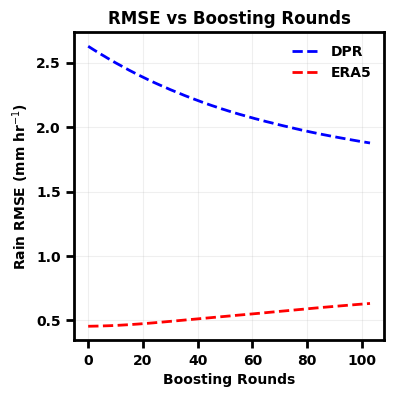

In [ ]:
# Extract RMSE values
train_rmse = evals_result['test_dpr']['rmse']
test_rmse = evals_result['test_era5']['rmse']

# Plot RMSE vs Boosting rounds
plt.figure(figsize=(4, 4))
plt.plot(train_rmse, label='DPR', color='blue', linestyle='--', linewidth=2)
plt.plot(test_rmse, label='ERA5', color='red', linestyle='--', linewidth=2)

plt.xlabel('Boosting Rounds', fontsize=10, fontweight='bold')
plt.ylabel('Rain RMSE (mm hr$^{-1}$)', fontsize=10, fontweight='bold')


plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)
plt.title('RMSE vs Boosting Rounds', fontsize=12, fontweight='bold')
plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight':'bold'})
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
plt.grid(True, alpha=0.2)
plt.show()

# **3.  Orbial Retrievals**

In this section, the pre-trained models are loaded to retrieve rainfall and snowfall for two GMI orbits.

## **3.1) Running B-RAINS for the selected orbit**

In [ ]:
path_orbit_004780 = 'Orbit_004780/GPM_orbit_004780.npz'

# Load the .npz file
npz_004780 = np.load(path_orbit_004780)

In [ ]:
[phase, rain, snow, latitude, longitude] = TLPR2S_model(path_orbit_004780, booster_cpr, booster_dpr, meta_model,
                     snow_rate_booster, rain_rate_booster,
                     df_cdf_rain, df_cdf_snow);

/content/Microwave_Precipitation_Retrievals_from_TLP-R2S/Microwave_Precipitation_Retrievals_from_TLP-R2S/Microwave_Precipitation_Retrievals_from_TLP-R2S/pmw_utils.py:280: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0388816  0.0399763  0.11648546 ... 0.0530806  0.06047127 0.06047127]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df_snowr.index, 'pred_snow_rate'] = actual_snow_values
/content/Microwave_Precipitation_Retrievals_from_TLP-R2S/Microwave_Precipitation_Retrievals_from_TLP-R2S/Microwave_Precipitation_Retrievals_from_TLP-R2S/pmw_utils.py:290: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01116959 0.02735633 0.03648969 ... 0.01858145 0.0344056  0.01256065]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df_rain

In [ ]:
!pip install cartopy
import cartopy.crs as ccrs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 93.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


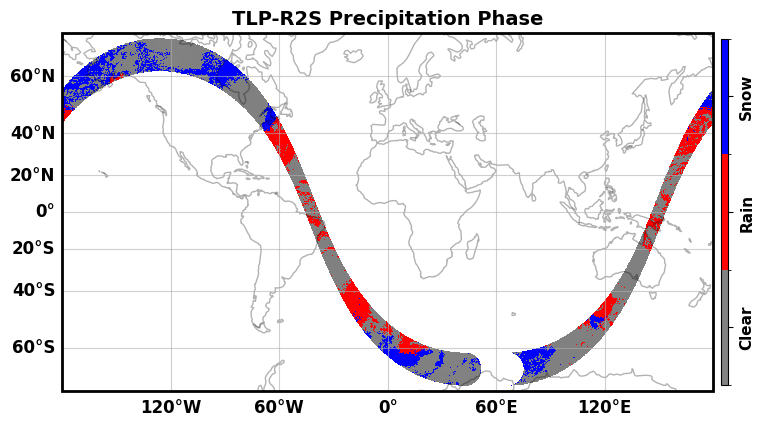

In [ ]:
cmap_custom = mcolors.ListedColormap(['grey', 'red', 'blue'])
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap_custom.N)

# Create figure for ERA5_flag
fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(111, projection=ccrs.Mercator())

mask = (longitude > 179.5) | (longitude < -179.5)
ERA5_flag_2d_masked = np.ma.masked_where(mask, phase)

# Plot using pcolormesh
plot1 = ax1.pcolormesh(longitude, latitude, ERA5_flag_2d_masked, cmap=cmap_custom, norm=norm, alpha=0.98, transform=ccrs.PlateCarree())
ax1.coastlines(alpha=0.3)

g4 = ax1.gridlines(draw_labels=True, alpha=0.6)
g4.top_labels = False
g4.right_labels = False
g4.xlabels_bottom = True
g4.ylabels_left = True
g4.xlabel_style = {'fontsize': 12, 'fontweight': 'bold'}
g4.ylabel_style = {'fontsize': 12, 'fontweight': 'bold'}


cbar1 = plt.colorbar(plot1, ax=ax1, orientation='vertical', shrink=0.75, pad=0.01, aspect=50)
cbar1.set_ticks([0.5, 1.5, 2.5])
cbar1.set_ticklabels(['Clear', 'Rain', 'Snow'])
for t in cbar1.ax.get_yticklabels():
    t.set_fontweight('bold')
    t.set_fontsize(11)
    t.set_rotation(90)
    t.set_ha('center')
    t.set_va('center')
cbar1.ax.tick_params(pad=10)
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
for spine in ax1.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
ax1.set_title('TLP-R2S Precipitation Phase', fontsize=14, fontweight='bold')


plt.show()

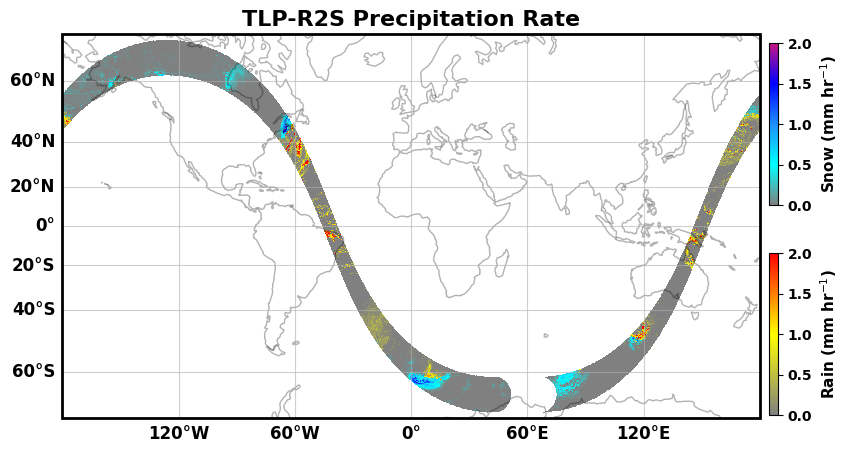

In [ ]:
# Define color maps
from matplotlib.colors import LinearSegmentedColormap
colors_snow = ['grey', 'cyan', 'dodgerblue', 'blue', 'mediumvioletred']
cmap_rate_snow = LinearSegmentedColormap.from_list("mycmap_snow", colors_snow)

colors_rain = ['grey', 'yellow', 'red']
cmap_rate_rain = LinearSegmentedColormap.from_list("mycmap_rain", colors_rain)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.Mercator()})
mask = (longitude > 179.5) | (longitude < -179.5)

snow_masked = np.ma.masked_where(mask, snow)
rain_masked = np.ma.masked_where(mask, rain)

snow_rate_masked = np.ma.masked_where(rain_masked > snow_masked, snow)
rain_rate_masked = np.ma.masked_where(snow_masked > rain_masked, rain)

# Plot snow and rain
plot1 = ax1.pcolormesh(longitude, latitude, snow_rate_masked, vmin=0, vmax=2,
                       cmap=cmap_rate_snow, transform=ccrs.PlateCarree())
plot2 = ax1.pcolormesh(longitude, latitude, rain_rate_masked, vmin=0, vmax=2,
                       cmap=cmap_rate_rain, transform=ccrs.PlateCarree())

# Coastlines and grid
ax1.coastlines(alpha=0.3)
g4 = ax1.gridlines(draw_labels=True, alpha=0.6)
g4.top_labels = False
g4.right_labels = False
g4.xlabels_bottom = True
g4.ylabels_left = True
g4.xlabel_style = {'fontsize': 12, 'fontweight': 'bold'}
g4.ylabel_style = {'fontsize': 12, 'fontweight': 'bold'}
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
for spine in ax1.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
ax1.set_title('TLP-R2S Precipitation Rate', fontsize=16, fontweight='bold')


cbar_ax1 = fig.add_axes([0.91, 0.53, 0.01, 0.27])
cbar_ax2 = fig.add_axes([0.91, 0.18, 0.01, 0.27])

cbar1 = fig.colorbar(plot1, cax=cbar_ax1)
cbar1.set_label('Snow (mm hr$^{-1}$)', fontsize=11, fontweight='bold')
for t in cbar1.ax.get_yticklabels():
    t.set_fontweight('bold')

cbar2 = fig.colorbar(plot2, cax=cbar_ax2)
cbar2.set_label('Rain (mm hr$^{-1}$)', fontsize=11, fontweight='bold')
for t in cbar2.ax.get_yticklabels():
    t.set_fontweight('bold')

plt.show()

/tmp/ipython-input-28-2878991394.py:109: RuntimeWarning: divide by zero encountered in log2
  im7 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(rain_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
/tmp/ipython-input-28-2878991394.py:112: RuntimeWarning: divide by zero encountered in log2
  im7_1 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(snow_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
/tmp/ipython-input-28-2878991394.py:122: RuntimeWarning: divide by zero encountered in log2
  im4 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(rain_rate_era5_masked+ 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
/tmp/ipython-input-28-2878991394.py:122: RuntimeWarning: invalid value encountered in log2
  im4 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(rain_rate_era5_masked+ 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
/tmp/ipython-input-28-2878991394.py:126: RuntimeWar

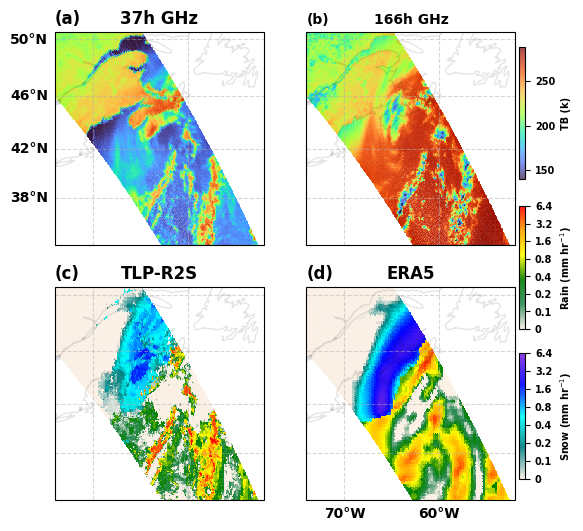

In [ ]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
from matplotlib.colors import PowerNorm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, LogNorm
from matplotlib.ticker import LogLocator, FuncFormatter
import warnings
#import colorcet as cc

# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy.mpl.gridliner")


#colors_1 = ['grey', 'lawngreen', 'gold', 'darkorange']
colors_1 = ['linen', 'seagreen' ,'green', 'yellow', 'orange', 'red']



rate_colors = ['linen', 'teal', 'cyan', 'blue', 'blueviolet']  # For snow_rate plots

rate_bt = ['lightblue', 'teal','cyan', 'green', 'yellowgreen','yellow', 'red']

# Create colormap objects
cmap_rain = LinearSegmentedColormap.from_list("mycmap_rain", colors_1, N=256)
cmap_snow = LinearSegmentedColormap.from_list("mycmap_snow", rate_colors)
cmap_bt = LinearSegmentedColormap.from_list("mycmap_snow", rate_bt)


new_cmap = cmap_rain
my_cmap = cmap_snow


# Mask data based on lon_2d values
mask = (longitude > -52) | (longitude < -74)

snow_rate_masked = np.ma.masked_where(rain_masked > snow_masked, snow)
rain_rate_masked = np.ma.masked_where(snow_masked > rain_masked, rain)

snow_pred_2d = np.ma.masked_where(mask, snow)
rain_pred_2d = np.ma.masked_where(mask, rain)
snow_rate_masked = np.ma.masked_where(rain_pred_2d > snow_pred_2d, snow)
rain_rate_masked = np.ma.masked_where(snow_pred_2d > rain_pred_2d, rain)


snow_era5 = npz_004780['snow_era5']
rain_era5= npz_004780['rain_era5']
snow_era5_2d = np.ma.masked_where(mask, snow_era5)
rain_era5_2d = np.ma.masked_where(mask, rain_era5)

snow_rate_era5_masked = np.ma.masked_where(rain_era5_2d > snow_era5_2d, snow_era5)
rain_rate_era5_masked = np.ma.masked_where(snow_era5_2d > rain_era5_2d, rain_era5)



tb_37h= npz_004780['36h']
tb_166h= npz_004780['166h']
tb_37h_2d = np.ma.masked_where(mask, tb_37h)
tb_166h_2d = np.ma.masked_where(mask, tb_166h)
# Plotting
fig, axes = plt.subplots(
    2, 2, figsize=(6, 6), subplot_kw={'projection': ccrs.Mercator()},
    gridspec_kw={'height_ratios': [1, 1], 'left': 0.05, 'bottom': 0.2,
                 'right': 0.85, 'top': 0.98, 'hspace': 0.2, 'wspace': 0.1})

import matplotlib.ticker as mticker  # Ensure mticker is imported

# Helper function to configure gridlines with custom intervals
def configure_gridlines(ax, x_bottom=True, y_left=True, lat_interval=10, lon_interval=10):
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = y_left
    gl.bottom_labels = x_bottom

    # Set custom intervals for latitude and longitude labels
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, lon_interval))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, lat_interval))
    ax.set_xticks(np.arange(-180, 181, lon_interval))
    ax.set_yticks(np.arange(-90, 91, lat_interval))


    gl.xlabel_style = {'fontsize': 10, 'fontweight': 'bold'}
    gl.ylabel_style = {'fontsize': 10, 'fontweight': 'bold'}



# Plot 1: 37h
im1 = axes[0, 0].pcolormesh(longitude, latitude, tb_37h_2d,  vmin=140, vmax=288,
                            cmap= 'turbo', alpha=0.7, transform=ccrs.PlateCarree())
axes[0, 0].coastlines(alpha=0.1)
configure_gridlines(axes[0, 0], lat_interval=4, lon_interval=10, y_left=True, x_bottom=False)
axes[0, 0].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[0, 0].set_title('37h GHz', fontsize=12, fontweight='bold')
axes[0, 0].set_title('(a)', fontsize=12, fontweight='bold', loc='left')

# Plot 4: 166h
im3 = axes[0, 1].pcolormesh(longitude, latitude, tb_166h_2d, vmin=140, vmax=288,
                            cmap= 'turbo', alpha=0.7, transform=ccrs.PlateCarree())
axes[0, 1].coastlines(alpha=0.1)
configure_gridlines(axes[0, 1], lat_interval=4, lon_interval=10, y_left=False, x_bottom=False)
axes[0, 1].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[0, 1].set_title('166h GHz', fontsize=10, fontweight='bold')
axes[0, 1].set_title('(b)', fontsize=10, fontweight='bold', loc='left')

# Plot 6: Rain and snow from B-RAIN
im7 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(rain_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=new_cmap, alpha=0.9, transform=ccrs.PlateCarree())
snow_pred_2d = np.where(snow_pred_2d < rain_pred_2d, np.nan, snow_pred_2d)
im7_1 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(snow_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=cmap_snow, alpha=0.9, transform=ccrs.PlateCarree())
axes[1, 0].coastlines(alpha=0.1)
configure_gridlines(axes[1, 0], lat_interval=4 , lon_interval=10, y_left=False, x_bottom=False)
axes[1, 0].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[1, 0].set_title('TLP-R2S', fontsize=12, fontweight='bold')
axes[1, 0].set_title('(c)', fontsize=12, fontweight='bold', loc='left')


# Plot 5: Rain and snow from ERA5
im4 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(rain_rate_era5_masked+ 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=new_cmap, alpha=0.9, transform=ccrs.PlateCarree())
snow_era5_2d = np.where(snow_era5_2d < rain_era5_2d, np.nan, snow_era5_2d)

im4_1 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(snow_rate_era5_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=cmap_snow, alpha=0.9, transform=ccrs.PlateCarree())
axes[1, 1].coastlines(alpha=0.1)
configure_gridlines(axes[1, 1], lat_interval=4, lon_interval=10, y_left=False, x_bottom=True)
axes[1, 1].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[1, 1].set_title('ERA5', fontsize=12, fontweight='bold')
axes[1, 1].set_title('(d)', fontsize=12, fontweight='bold', loc='left')

from matplotlib import ticker

# Upper row colorbar (Snow Rate)
cbar_ax1 = fig.add_axes([0.84, 0.735, 0.01, 0.22])  # Position for the upper row colorbar
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical')
cbar1.set_label('TB (k)', fontsize=7, fontweight='bold')

# Set tick label properties
for tick in cbar1.ax.get_yticklabels():
    tick.set_fontsize(7)
    tick.set_fontweight('bold')

############################################################################################################
cbar_ax2 = fig.add_axes([0.84, 0.485, 0.01, 0.205])
cbar2 = fig.colorbar(im4, cax=cbar_ax2, orientation='vertical', label='Rain Rate (mm hr$^{{-1}}$)')
rain_ticks = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
log_ticks = np.log2(np.clip(rain_ticks, 1e-10, None))

cbar2.set_ticks(log_ticks)

tick_labels = ['0' if tick == 0.05 else f"{tick:.1f}" for tick in rain_ticks]
cbar2.set_ticklabels([f"{tick}" for tick in tick_labels])

# Set tick label properties
for tick in cbar2.ax.get_yticklabels():
    tick.set_fontsize(7)
    tick.set_fontweight('bold')


cbar2.set_label('Rain (mm hr$^{-1}$)', fontsize=7, fontweight='bold')
###########################################################################################
cbar_ax3 = fig.add_axes([0.84, 0.235, 0.01, 0.21])
cbar3 = fig.colorbar(im7_1, cax=cbar_ax3, orientation='vertical')
snow_ticks = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
log_ticks = np.log2(np.clip(snow_ticks, 1e-10, None))

cbar3.set_ticks(log_ticks)

tick_labels = ['0' if tick == 0.05 else f"{tick:.1f}" for tick in snow_ticks]
cbar3.set_ticklabels([f"{tick}" for tick in tick_labels])

# Set tick label properties
for tick in cbar3.ax.get_yticklabels():
    tick.set_fontsize(7)
    tick.set_fontweight('bold')


cbar3.set_label('Snow (mm hr$^{-1}$)', fontsize=7, fontweight='bold')


plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()